In [3]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("NYC_Taxi_Analysis").getOrCreate()

# Load the Parquet file
df = spark.read.parquet('Tripdata.parquet')

# Show the first few rows
df.show(5)

# Check schema
df.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7|  1.0|    0.5|       0.

In [4]:
df.printSchema()
df.describe().show()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+---

In [5]:
from pyspark.sql.functions import col

df = df.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast("timestamp")) \
       .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast("timestamp"))


# 1**. Peak Hours – Find Most Active Hours for Rides**


In [6]:
from pyspark.sql.functions import hour, count

df_peak_hours = df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                  .groupBy("pickup_hour").agg(count("*").alias("ride_count")) \
                  .orderBy("ride_count", ascending=False)

df_peak_hours.show(10)

+-----------+----------+
|pickup_hour|ride_count|
+-----------+----------+
|         18|    212788|
|         17|    206257|
|         16|    190201|
|         15|    189359|
|         19|    184032|
|         14|    182898|
|         13|    169903|
|         12|    164559|
|         21|    160888|
|         20|    159989|
+-----------+----------+
only showing top 10 rows



The above show the hours when taxi demand is highest.

# 2. Most Popular Pickup & Dropoff Locations

In [7]:
from pyspark.sql.functions import desc

df_pickup_popular = df.groupBy("PULocationID") \
                      .agg(count("*").alias("num_pickups")) \
                      .orderBy(desc("num_pickups"))

df_pickup_popular.show(10)

+------------+-----------+
|PULocationID|num_pickups|
+------------+-----------+
|         132|     145240|
|         161|     143471|
|         237|     142708|
|         236|     136465|
|         162|     106717|
|         230|     106324|
|         186|     104523|
|         142|     104080|
|         138|      89533|
|         239|      88474|
+------------+-----------+
only showing top 10 rows



# 3. Average Trip Duration Per Borough

In [8]:
from pyspark.sql.functions import unix_timestamp, avg

df_duration = df.withColumn("trip_duration",
                            (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

df_avg_duration = df_duration.groupBy("PULocationID") \
                             .agg(avg("trip_duration").alias("avg_trip_duration")) \
                             .orderBy(desc("avg_trip_duration"))

df_avg_duration.show(10)

+------------+------------------+
|PULocationID| avg_trip_duration|
+------------+------------------+
|          44| 82.63333333333334|
|         184| 60.83333333333333|
|          86| 59.51951515151516|
|         117| 56.50515394912983|
|          30| 56.01666666666667|
|         220|55.706971677559885|
|          55| 55.30095720720722|
|         240| 53.06111111111111|
|         108|  51.2764705882353|
|         210| 50.93799368088467|
+------------+------------------+
only showing top 10 rows



This shows the average trip duration per pickup location.

In [16]:
df.describe()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string, congestion_surcharge: string, Airport_fee: string]

Now we will show some ways to **Optimize** Performance (Partitioning, Caching, Broadcast Joins)

In [9]:
df.cache()  # Stores the dataframe in memory

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double]

This caching process helps improve performance when we run multiple queries on the same dataframe.





We use Partitioning for Faster Queries
Partitioning helps when dealing with large datasets. We can partition by date or location.

In [17]:
from pyspark.sql.functions import hour

# Add 'pickup_hour' column
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

# Now write the partitioned file
df.write.partitionBy("pickup_hour").parquet("taxi_data_partitioned.parquet")

Sensibly, queries that filter by pickup_hour will be much faster.

Saving as a CSV

In [19]:
df_avg_duration.write.mode("overwrite").csv("output/avg_trip_duration.csv", header=True)

Now we will do some plotting of graphs. Since Pyspark is not that efficient in plots, we use Pandas for the same.

In [20]:
!pip install matplotlib seaborn plotly pandas

In [21]:
import pandas as pd

# Convert PySpark DataFrame to Pandas for visualization
df_peak_hours_pd = df_peak_hours.toPandas()
df_pickup_popular_pd = df_pickup_popular.toPandas()
df_avg_duration_pd = df_avg_duration.toPandas()

# Peak Hours - Bar Chart

<ipython-input-22-238b624eb55c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_peak_hours_pd["pickup_hour"], y=df_peak_hours_pd["ride_count"], palette="Blues_r")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128662 (\N{ONCOMING TAXI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


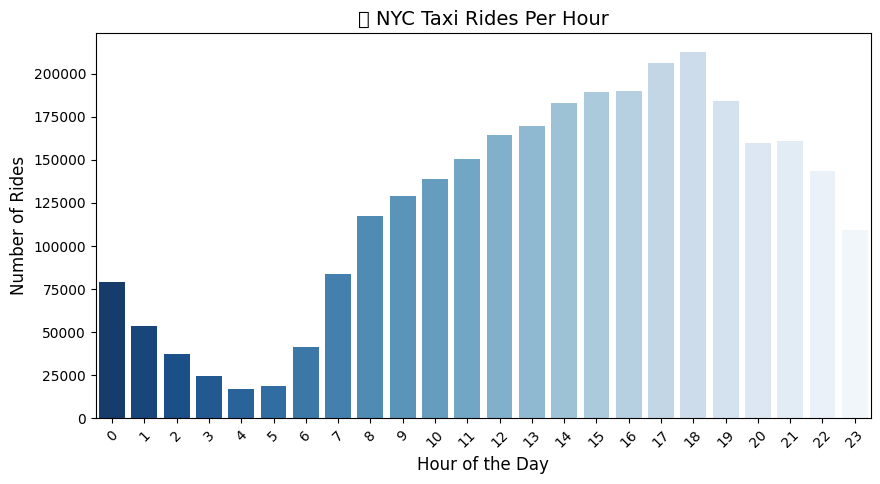

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=df_peak_hours_pd["pickup_hour"], y=df_peak_hours_pd["ride_count"], palette="Blues_r")

plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.title("🚖 NYC Taxi Rides Per Hour", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Most Popular Pickup Locations - Bar Chart

<ipython-input-23-5fdf8509e481>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_pickup_popular_pd["PULocationID"][:10],
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


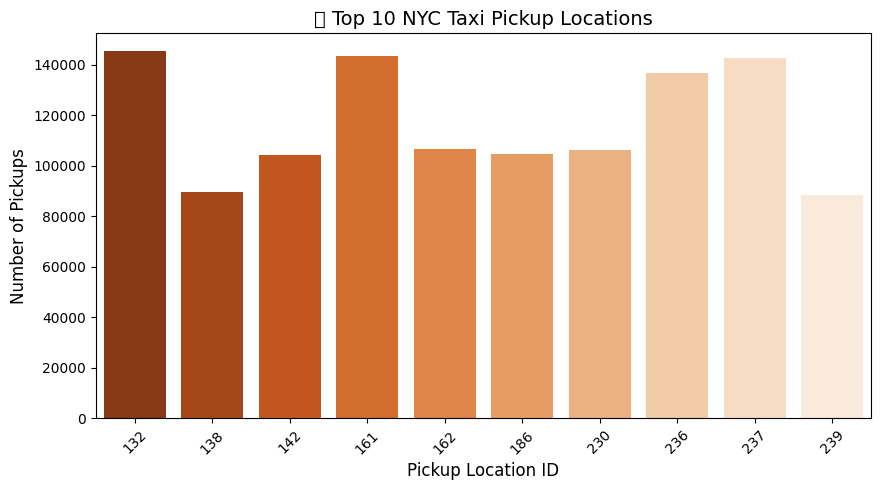

In [23]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df_pickup_popular_pd["PULocationID"][:10],
            y=df_pickup_popular_pd["num_pickups"][:10], palette="Oranges_r")

plt.xlabel("Pickup Location ID", fontsize=12)
plt.ylabel("Number of Pickups", fontsize=12)
plt.title("📍 Top 10 NYC Taxi Pickup Locations", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Avg. Trip Duration Per Borough - Bar Chart


<ipython-input-27-cd4084add6ca>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.



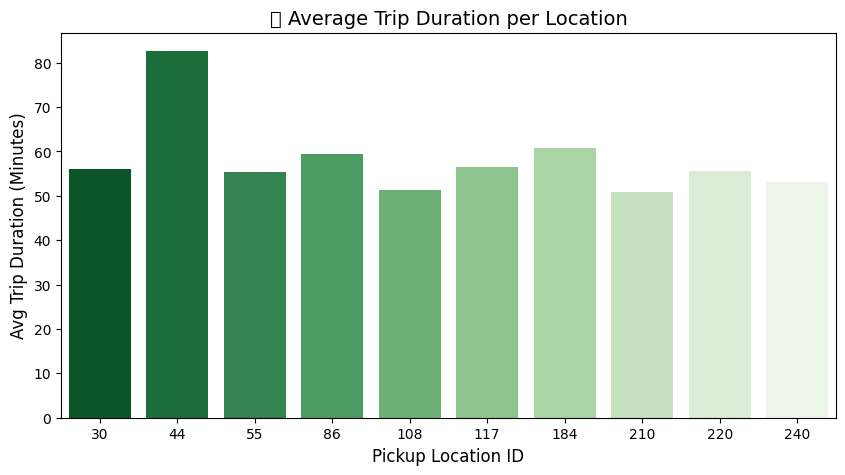

In [27]:
plt.figure(figsize=(10, 5))

# Use y-axis for Boroughs (PULocationID) and x-axis for Trip Duration
sns.barplot(y=df_avg_duration_pd["avg_trip_duration"][:10],
            x=df_avg_duration_pd["PULocationID"][:10],
            palette="Greens_r")

plt.ylabel("Avg Trip Duration (Minutes)", fontsize=12)
plt.xlabel("Pickup Location ID", fontsize=12)
plt.title("⏳ Average Trip Duration per Location", fontsize=14)
plt.show()